In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os,sys
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 18})

In [5]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt

In [6]:
sys.path.append('../training')
from manifoldembedder import *
from anomalymodels import *

In [7]:
basedir = '/nobackup/users/sangeon/datasets/jets/jetpairs/simple'

file_dict = {'train':os.path.join(basedir, 'simple_jettrain_16part.pt'),
             'val':os.path.join(basedir, 'simple_jetval_16part.pt'),
             'test':None,
             'predict':os.path.join(basedir, 'simple_jetpredict_16part.pt')}

In [8]:
trainer = Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
embedder = ManifoldEmbedder.load_from_checkpoint("../training/simpletoyjets_checkpoints/Transformer-paper-finalJHEP5-checkpoint-epoch=06-val_loss=0.49.ckpt")

In [10]:
embedder.eval()


ManifoldEmbedder(
  (encoder): particleTransformer(
    (embed_src): Linear(in_features=3, out_features=32, bias=True)
    (embed_tgt): Linear(in_features=3, out_features=32, bias=True)
    (pos_enc): PositionalEncoding(
      (dropout): Dropout(p=0.26, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): Tra

In [11]:
jetsimple_dm = JetDataModule(file_dict,2500)


In [12]:
a = trainer.predict(embedder, jetsimple_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [13]:
label = np.array([])
embedding = np.empty((0,2))
for batch in a:
    #print(batch[0].shape)
    #print(batch[1].shape)
    embedding = np.vstack((embedding, batch[0].cpu().numpy()))
    label = np.concatenate([label, batch[1].cpu().numpy()])
    #print(batch[0], batch[1])

In [14]:
embedding

array([[-0.55313873, -0.14662617],
       [-0.58127731, -0.15523028],
       [-0.58338737, -0.15532801],
       ...,
       [-0.03435607, -0.1006385 ],
       [-0.01836406, -0.10177738],
       [-0.02787842, -0.10151891]])

In [15]:
label

array([1., 1., 1., ..., 4., 4., 4.])

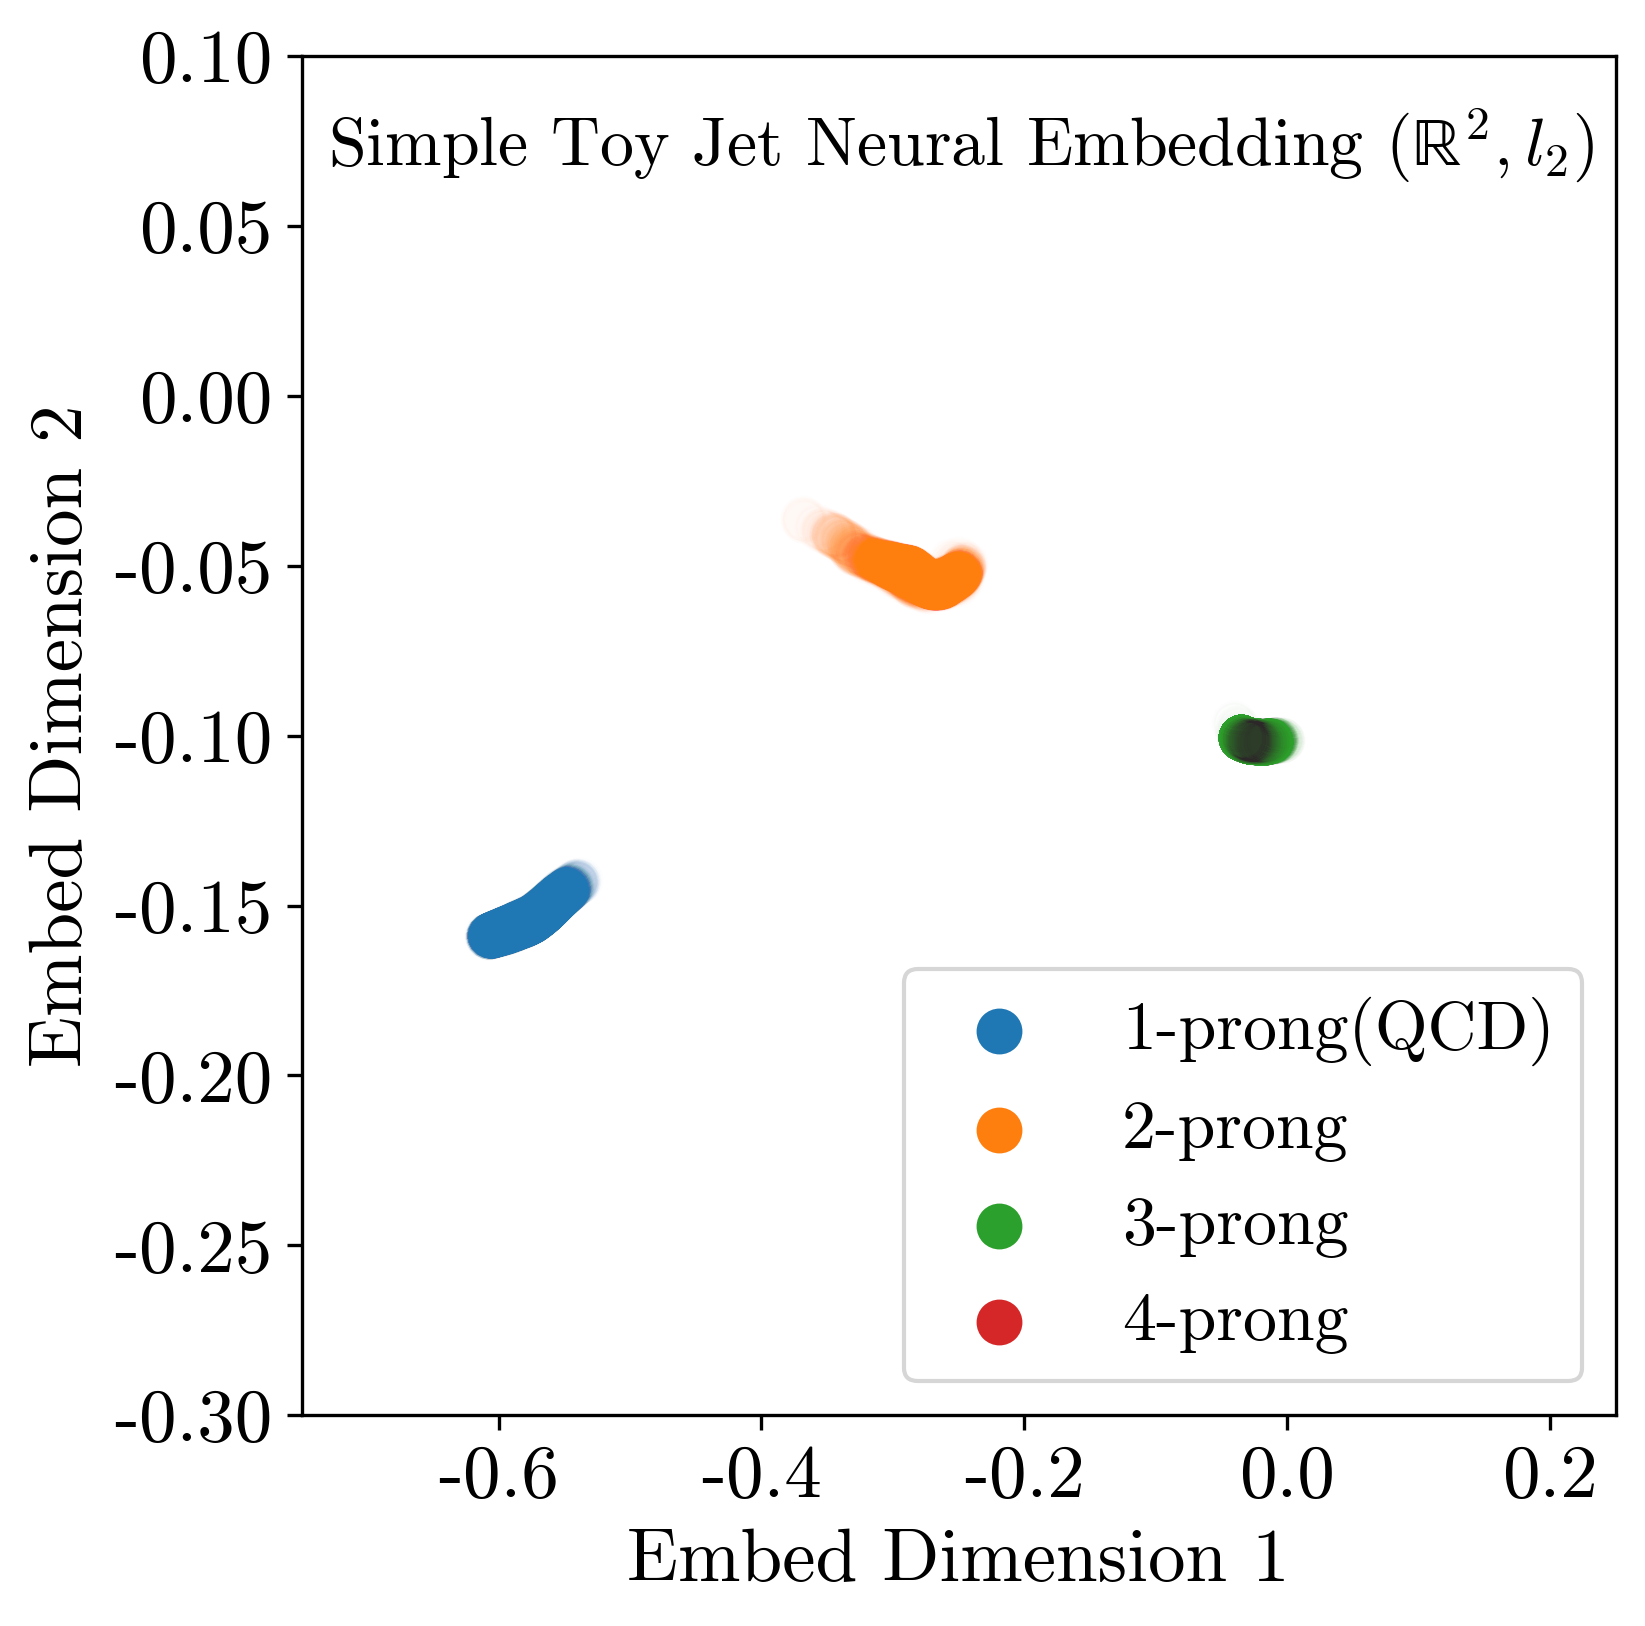

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(embedding[label==1][:10000,0],embedding[label==1][:10000,1],s=100,alpha=0.01,label='1-prong(QCD)')
ax.scatter(embedding[label==2][:10000,0],embedding[label==2][:10000,1],s=100,alpha=0.01,label='2-prong')
ax.scatter(embedding[label==3][:10000,0],embedding[label==3][:10000,1],s=100,alpha=0.01,label='3-prong')
ax.scatter(embedding[label==4][:100,0],embedding[label==4][:100,1],s=100,alpha=0.005,label='4-prong')

ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-.75,.25])
ax.set_ylim([-.3,0.1])
leg = ax.legend(fontsize=16.3, loc='lower right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.text(0.02, 0.92, r'Simple Toy Jet Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$', transform=ax.transAxes, fontsize = 16.3)   
#ax.text(0.05, 0.86, r'Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$', transform=ax.transAxes)    
plt.subplots_adjust(left=0.17)

fig.savefig(f'../figures/paper_JHEP/SimpleToyJet_Embedding_ScatterPlot.png')    
fig.savefig(f'../figures/paper_JHEP/SimpleToyJet_Embedding_ScatterPlot.pdf')

In [17]:
from sklearn.neighbors import KernelDensity
from scipy import interpolate

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[-0.75:0.25:xbins, 
                      -0.3:0.1:ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [18]:
def plot_KDE_cdf_contour(ax, whichlabel, cdfval, color):
    xx, yy, zz = kde2D(embedding[label==whichlabel][:500000,0], embedding[label==whichlabel][:500000,1], .005, kernel='gaussian')
    hist = zz/zz.sum()
    n = 1000
    t = np.linspace(0, hist.max(), n)
    integral = ((hist >= t[:, None, None]) * hist).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)
    t_contours = f(np.array([cdfval]))
    
    #ax.imshow(hist.T, origin='lower', extent=[-0.1, 0.4, -0.05, 0.35], cmap="gray",aspect='auto')
    CS = ax.contour(hist.T, t_contours, extent=[-0.75,0.25,-0.3,0.1],colors=color, alpha=0.8)
    
    #fig.set_size_inches(8, 8)
    return CS
    

In [19]:
namelist = ['1-prong(QCD)','2-prong','3-prong','4-prong']

In [20]:
label

array([1., 1., 1., ..., 4., 4., 4.])

In [21]:
embedding

array([[-0.55313873, -0.14662617],
       [-0.58127731, -0.15523028],
       [-0.58338737, -0.15532801],
       ...,
       [-0.03435607, -0.1006385 ],
       [-0.01836406, -0.10177738],
       [-0.02787842, -0.10151891]])

In [22]:
embedding.shape

(1600000, 2)

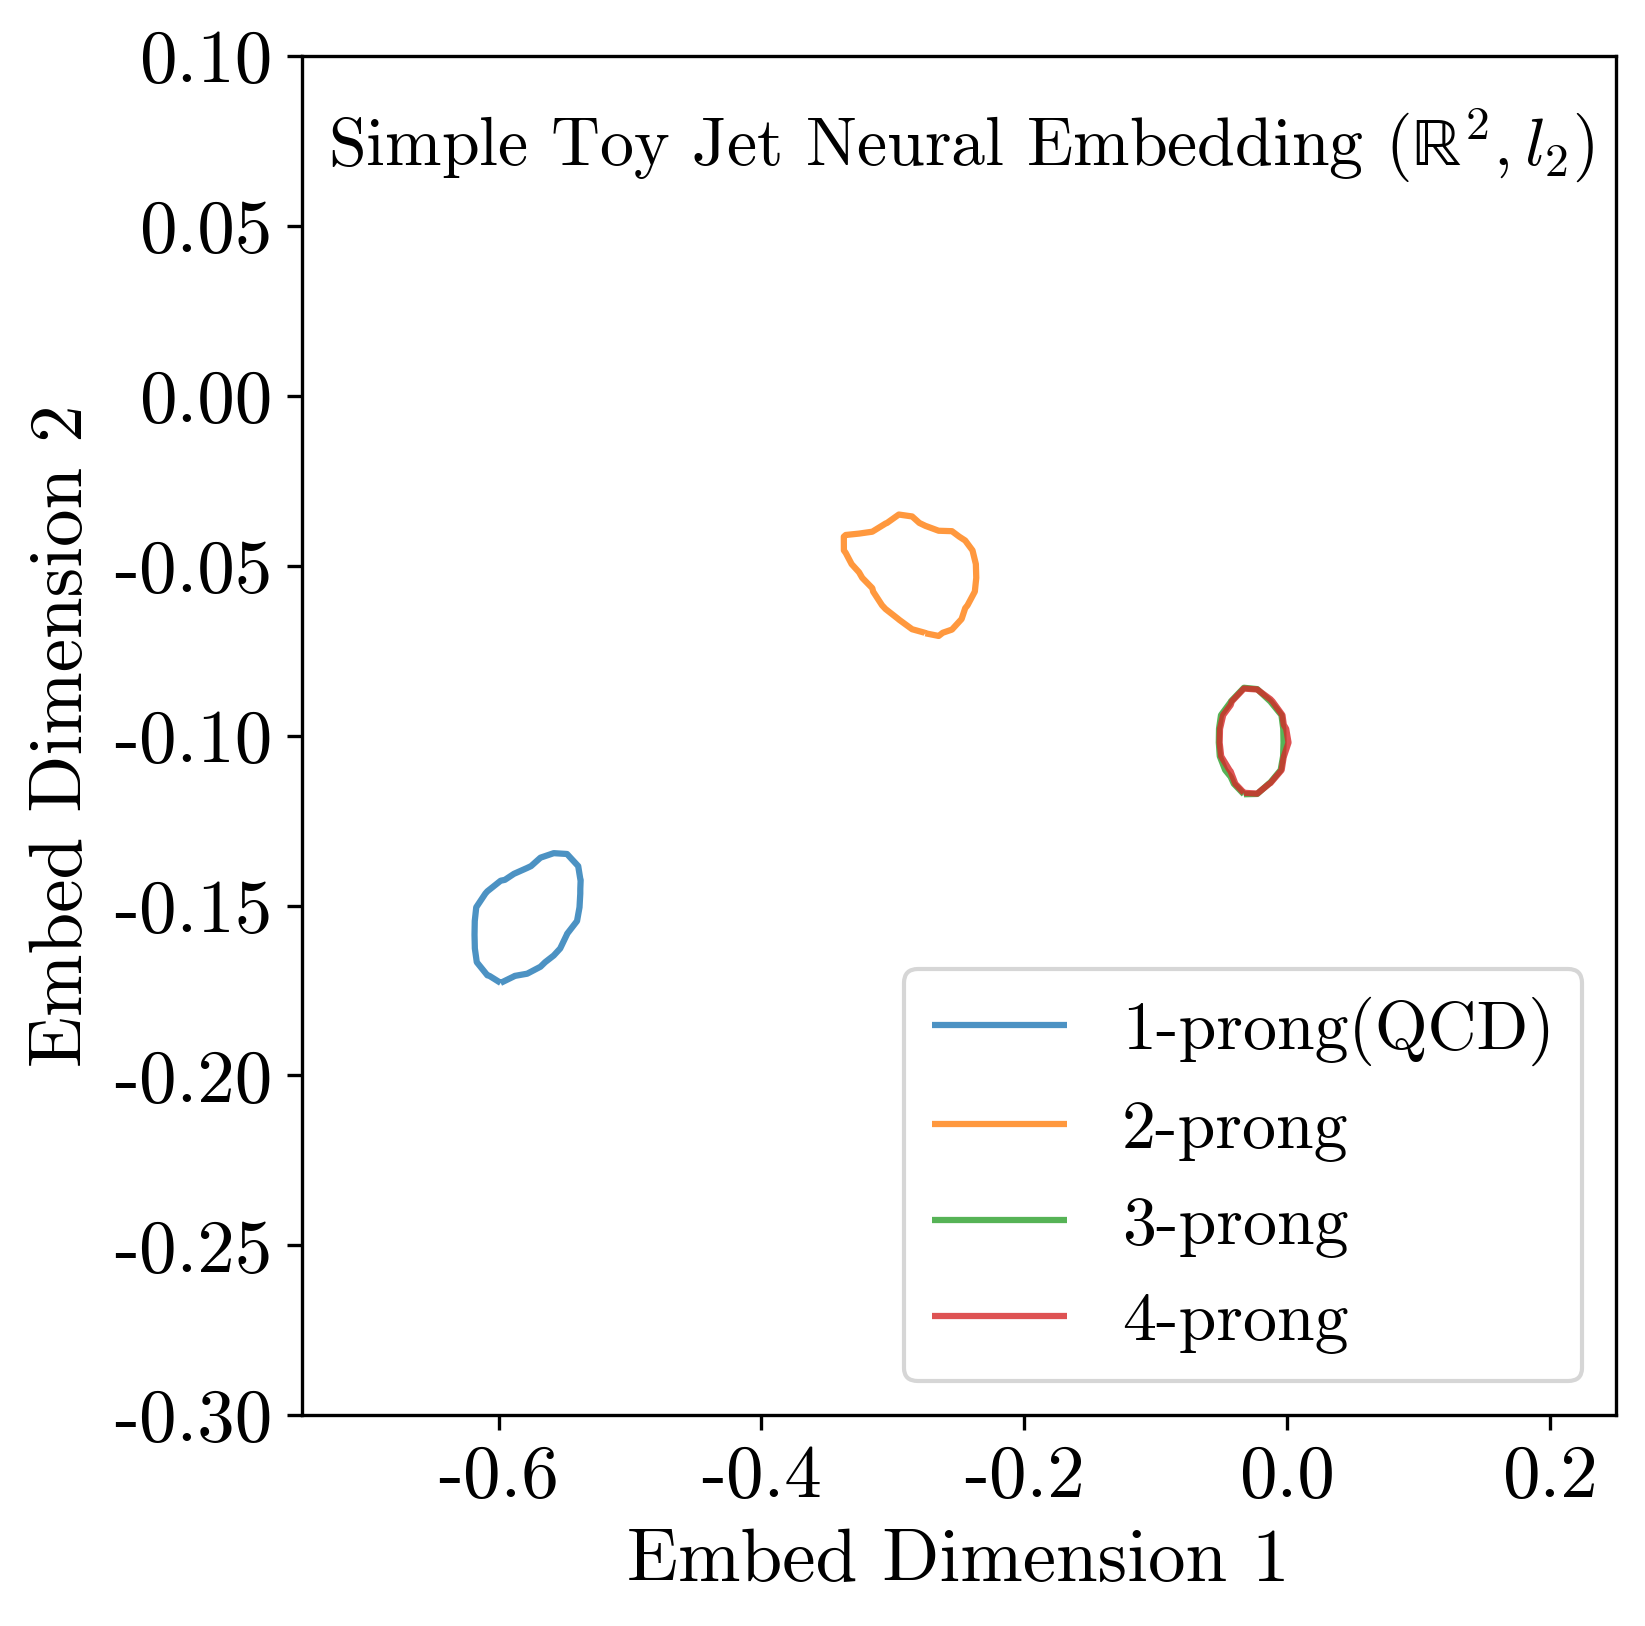

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
lines = []
for i in range(0,4):
    CS = plot_KDE_cdf_contour(ax, i+1, [0.99], f'C{i}')
    lines.append(CS.collections[0])


ax.set_xlabel('Embed Dimension 1')
ax.set_ylabel('Embed Dimension 2')
ax.set_xlim([-.75,.25])
ax.set_ylim([-.3,.1])
ax.legend(lines, namelist, fontsize=16.3, loc='lower right')
#ax.set_title('Simple Toy Jet Embedding') 
ax.text(0.02, 0.92, r'Simple Toy Jet Neural Embedding $(\mathrm{\mathbb{R}}^2, l_2)$', transform=ax.transAxes, fontsize = 16.3)   

plt.subplots_adjust(left=0.17)

fig.savefig(f'../figures/paper_JHEP/SimpleToyJet_Embedding_ContourPlot.png')
fig.savefig(f'../figures/paper_JHEP/SimpleToyJet_Embedding_ContourPlot.pdf')

In [39]:
with open(f'/nobackup/users/sangeon/datasets/jets/jetpairs/realistic/realistic_jetpredict_zthetatest_16part_z.pickle', 'rb') as handle:
    predict_z = pickle.load(handle)

In [40]:
with open(f'/nobackup/users/sangeon/datasets/jets/jetpairs/realistic/realistic_jetpredict_zthetatest_16part_theta.pickle', 'rb') as handle:
    predict_theta = pickle.load(handle)

(-0.05, 0.45)

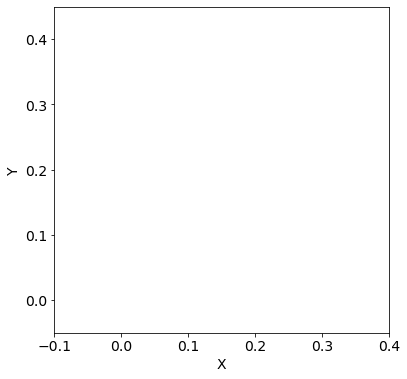

In [93]:
fig2 = plt.figure()
ax_c = fig2.add_subplot(1,1,1)
ax_c.set_xlabel('X')
ax_c.set_ylabel('Y')
ax_c.set_xlim([-0.1,0.4])
ax_c.set_ylim([-0.05,0.45])

In [128]:
label

array([1., 1., 1., ..., 4., 4., 4.])

In [20]:
def plot_circle_and_fill_hist(ax_i, ax_j, center, radius, color):
    bins = np.linspace(0,1.5,41)
    circle1 = Circle(center, radius, color=color, alpha=0.2)
    diff = embedding - np.tile(np.array(center), (800000,1))
    dist = np.sqrt(np.sum(diff*diff, axis =1))
    indices = np.where(dist<radius)
    selected_z = predict_z[indices[0]]
    selected_theta = predict_theta[indices[0]]
    labelselected = label[indices[0]]
    ax_i.add_patch(circle1)
    #ax_j.hist(predict_theta[:,0],density=True,alpha=0.3, label='original mixture')
    ax_j.hist(selected_theta[labelselected==2,0],density=True,alpha=0.3, label='selected twoprong')
    ax_j.hist(selected_theta[labelselected==3,0],density=True,alpha=0.3, label='selected threeprong')
    ax_j.hist(selected_theta[labelselected==4,0],density=True,alpha=0.3, label='selected fourprong')
    ax_j.set_xlabel(r'Theta')
    ax_j.set_ylabel(r'Density')

    ax_j.legend(fontsize=10)

    return None

    

In [239]:
indices = plot_circle_and_fill_hist(ax0, ax2, (0.05,0.1),.04,'grey')

indices = plot_circle_and_fill_hist(ax, (0.17,0.03),.04,'grey')

In [248]:
selected_z = predict_z[indices[0]]
selected_theta = predict_theta[indices[0]]
labelselected = label[indices[0]]

(array([2.91320128e+00, 3.22544495e+00, 4.53719028e+00, 6.41387133e+00,
        8.42896967e+00, 8.70580427e+00, 6.90798889e+00, 2.92929631e-01,
        0.00000000e+00, 1.60950347e-03]),
 array([3.25061353e-06, 2.41420915e-02, 4.82809325e-02, 7.24197734e-02,
        9.65586143e-02, 1.20697455e-01, 1.44836296e-01, 1.68975137e-01,
        1.93113978e-01, 2.17252819e-01, 2.41391660e-01]),
 <BarContainer object of 10 artists>)

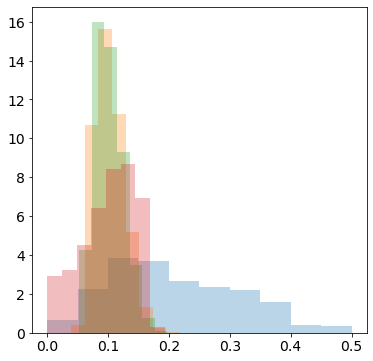

In [243]:
plt.hist(predict_z[:,0],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected_z[labelselected==1,0],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==2,0],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==3,0],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==4,0],density=True,alpha=0.3)

(array([1.98808566e-03, 2.21529545e-02, 1.63875061e-01, 6.80777332e-01,
        1.40784866e+00, 1.99859411e+00, 2.67369120e+00, 3.48170601e+00,
        3.91766480e+00, 3.83956143e+00]),
 array([0.9209671 , 0.97594883, 1.03093056, 1.08591229, 1.14089402,
        1.19587575, 1.25085748, 1.30583921, 1.36082094, 1.41580268,
        1.47078441]),
 <BarContainer object of 10 artists>)

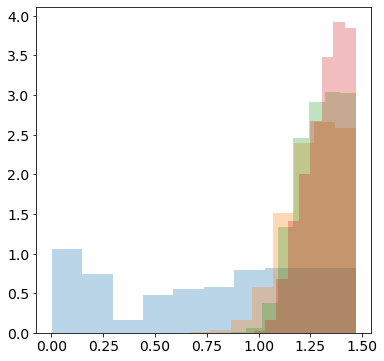

In [250]:
plt.hist(predict_theta[:,0],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected[labelselected==1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==2,0],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==3,0],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==4,0],density=True,alpha=0.3)

(array([0.70926115, 0.74611324, 0.736475  , 0.74469586, 0.70897767,
        0.74016021, 0.72286807, 0.71322983, 0.74838106, 0.72626981]),
 array([0.10002037, 0.23707366, 0.37412695, 0.51118024, 0.64823353,
        0.78528682, 0.92234011, 1.0593934 , 1.19644669, 1.33349998,
        1.47055327]),
 <BarContainer object of 10 artists>)

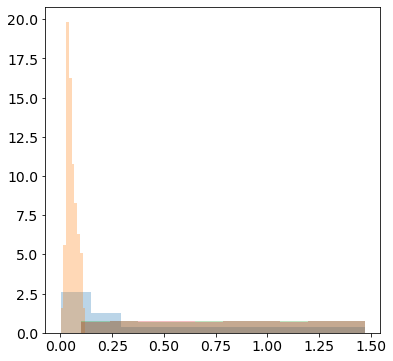

In [246]:
plt.hist(predict_theta[:,1],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected[labelselected==1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==2,1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==3,1],density=True,alpha=0.3)
plt.hist(selected_theta[labelselected==4,1],density=True,alpha=0.3)

(array([ 46.46021551,  65.72506318,  68.77796254,  75.02412445,
         82.67391824,  89.76225928, 100.67549721, 114.74690689,
        130.11667607, 129.23940614]),
 array([0.48892781, 0.49003498, 0.49114216, 0.49224933, 0.4933565 ,
        0.49446367, 0.49557084, 0.49667802, 0.49778519, 0.49889236,
        0.49999953]),
 <BarContainer object of 10 artists>)

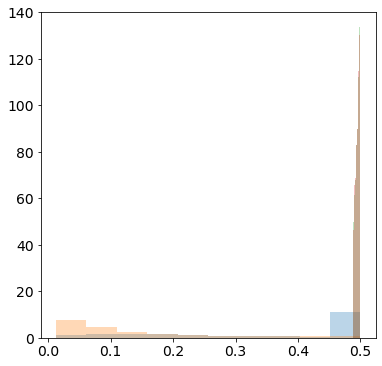

In [245]:
plt.hist(predict_z[:,1],density=True,alpha=0.3)
#plt.hist(predict_z[indices[0],0],density=True,alpha=0.3)
#plt.hist(selected[labelselected==1],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==2,1],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==3,1],density=True,alpha=0.3)
plt.hist(selected_z[labelselected==4,1],density=True,alpha=0.3)

In [136]:
predict_z[:,0]

array([0.40309423, 0.2621194 , 0.4759691 , ..., 0.26266149, 0.14370487,
       0.05567405])

In [108]:
plot_circle_and_fill_hist(ax, (0.3,0.19),.04,'C1')

In [109]:
plot_circle_and_fill_hist(ax, (0.17,0.03),.04,'C2')

In [112]:
embedding.shape

(800000, 2)

In [117]:
np.tile([0.02,0.23],(800000,1))

array([[0.02, 0.23],
       [0.02, 0.23],
       [0.02, 0.23],
       ...,
       [0.02, 0.23],
       [0.02, 0.23],
       [0.02, 0.23]])

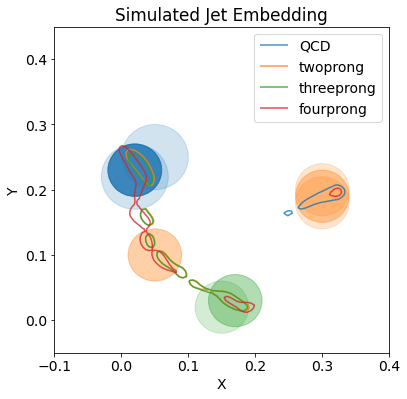

In [210]:
fig

In [69]:
ax_c

<AxesSubplot:xlabel='X', ylabel='Y'>

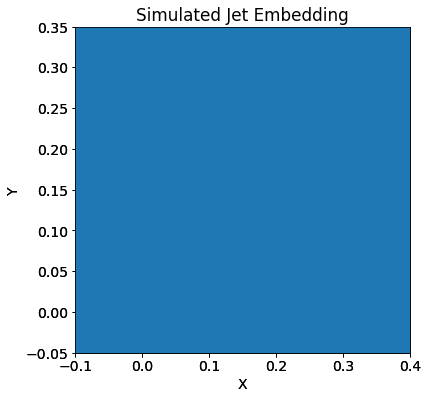

In [70]:
fig